<a href="https://colab.research.google.com/github/d4vidi4n/EL7037/blob/main/EL7037(CE)_Tarea_1_(GP)_Problema1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1 align="center"> EL7037 </h1>
<h2 align="center"> Tarea 1: Programación Genética </h2>
<h3 align="center"> Problema 1/2 - Regresión simbólica de funciones </h3>
***

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
# drive.mount('/content/drive/MyDrive/docs phd/2025-2/Computación Evolutiva/EL7037(2025_2)_T1_GP/GPalta/Code')
os.chdir('/content/drive/MyDrive/docs phd/2025-2/Computación Evolutiva/EL7037(2025_2)_T1_GP/GPalta/Code')

In [3]:
!pip install pydotplus
!pip install jpype1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 495.9/495.9 kB 8.1 MB/s eta 0:00:00


In [4]:
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Image
import pydotplus
import jpype
import os
from utilsGPalta import *
from tqdm import tqdm

In [5]:
libGPjar = 'GPaltav2.jar'
arg = '-Djava.class.path=%s'%os.path.join(os.getcwd(),libGPjar)
jvmPath = jpype.getDefaultJVMPath()
jpype.startJVM(jvmPath, arg)
GP = jpype.JPackage("gpalta")

### Configuración GP

In [6]:
config = GP.core.Config('Config.txt')
config.nGenerations   = 100     # numero de generaciones
config.populationSize = 60      # tamaño de la poblacion
config.maxDepth       = 6        # profundidad maxima
config.initialMinDepth= 3        # profundidad minima arboles poblacion inicial
config.initialMaxDepth= 4        # profundidad maxima arboles poblacion inicial
config.population     = 'gpalta.core.SingleTreePopulation'  # numero de salidas-arboles
config.fitness        = 'gpalta.core.FitnessClassic'        # criterio de fitness
config.constLowLimit  = 0
config.constUpLimit   = 10
prob_mutation         = 0.15
prob_crossover        = 0.7
# probability of crossover = upLimitProbCrossOver - 0
# probability of mutation = upLimitProbMutation - upLimitProbCrossOver
# probability of reproduction = 1 - upLimitProbMutation
config.upLimitProbCrossOver = prob_crossover
config.upLimitProbMutation  = prob_mutation + prob_crossover

# Más parámetros de configuracion de GP están en los archivos Config.txt y Nodes.txt

##### ---- Funciones disponibles ---
#['Cos', 'Sin', 'Exponential', 'Square', 'SquareRoot', 'Divide', 'Plus', 'Minus', 'Times']
selectedFuntion = ['Plus', 'Minus', 'Times','Divide']
setFuntions(selectedFuntion)

## Expresión matemática a encontrar
$$
f(x)=2\cdot x^{3}-x^{2}-x+5
$$

### Creación base de datos

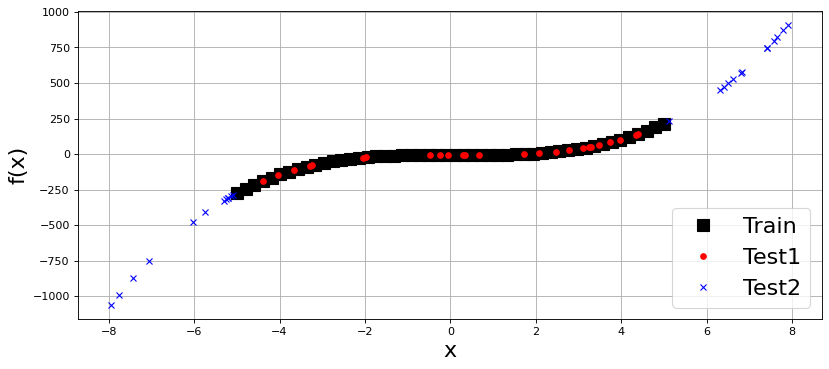

In [35]:
fnc = lambda x:(2*np.power(x,3)-np.power(x,2)-x-5)    # Funcion a determinar con programacion genetica
limitInner = [-5, 5]
limitOuter = [-8, 8]
###### --------- Entrenamiento ---------
n_train = 50
x_train = np.linspace(*limitInner,n_train)
y_train = fnc(x_train)
###### --------- Test 1 ---------
n_test1 = 25
x_test1 = randrange((n_test1,),limitInner)
y_test1 = fnc(x_test1)
###### --------- Test 2 ---------
n_test2 = 25
x_test2 = np.hstack( (randrange((int(np.fix(0.5*n_test2)),), (limitOuter[0],limitInner[0])),
                      randrange((int(n_test2-np.fix(0.5*n_test2)),), (limitInner[1],limitOuter[1]))) )
y_test2 = fnc(x_test2)

plt.close()
fig = plt.figure(figsize=(12, 5), dpi=80)
ax = fig.add_subplot(1,1,1)
ax.plot(x_train, y_train, 'ks', label='Train', linewidth=2,markersize=10)
ax.plot(x_test1, y_test1, 'ro', label='Test1', linewidth=1,markersize=5)
ax.plot(x_test2, y_test2, 'bx', label='Test2', linewidth=1,markersize=5)
ax.set_xlabel('x',size=20)
ax.set_ylabel('f(x)',size=20)
ax.grid()
ax.legend(loc='lower right',fontsize=20)

## Main loop GP

In [ ]:
# config.nGenerations   = 100     # numero de generaciones

In [8]:
names   = ['fitness', 'nodes', 'MSETrain', 'MSETest1', 'MSETest2', 'EvalTrain', 'EvalTest1', 'EvalTest2','tree']
formats = [float, float, float, float, float, float, float, float, object]
dtypes  = list(zip(names, formats))
dtypes[5] += ((n_train,),)
dtypes[6] += ((n_test1,),)
dtypes[7] += ((n_test2,),)

R = np.empty((config.populationSize, config.nGenerations),dtype=dtypes)

msefun = lambda x,y: np.mean(np.power(x-y,2))
evo = GP.core.Evolution(config, py2java(x_train,True),py2java(y_train), py2java(np.zeros((1, n_train))),True)
evo.eval()
for gen in tqdm(range(config.nGenerations), desc='Generation'):
    # ------ Condicion de termino GP por tolerancia fitness ---------------
    if (evo.evoStats.bestSoFar.readFitness() >= config.stopFitness):
        print('\nObjective reached in generation %d',gen)
        break
    evo.evolve()
    evo.eval()
    for ind in range(config.populationSize):
        R['fitness'][ind,gen]   = evo.population.get(ind).readFitness()
        R['nodes'][ind,gen]     = evo.population.get(ind).getMaxDepthFromHere()
        R['tree'][ind,gen]      = evo.population.get(ind)
        R['EvalTrain'][ind,gen] = java2py((evo.getRawOutput(evo.population.get(ind),py2java(x_train,True)).x))
        R['EvalTest1'][ind,gen] = java2py((evo.getRawOutput(evo.population.get(ind),py2java(x_test1,True)).x))
        R['EvalTest2'][ind,gen] = java2py((evo.getRawOutput(evo.population.get(ind),py2java(x_test2,True)).x))
        R['MSETrain'][ind,gen]  = msefun(R['EvalTrain'][ind,gen],y_train)
        R['MSETest1'][ind,gen]  = msefun(R['EvalTest1'][ind,gen],y_test1)
        R['MSETest2'][ind,gen]  = msefun(R['EvalTest2'][ind,gen],y_test2)

Generation: 100%|██████████| 100/100 [00:05<00:00, 18.40it/s]


In [36]:
msefun = lambda x,y: np.mean(np.power(x-y,2))

def evo_execution(config):
  names   = ['fitness', 'nodes', 'MSETrain', 'MSETest1', 'MSETest2', 'EvalTrain', 'EvalTest1', 'EvalTest2','tree']
  formats = [float, float, float, float, float, float, float, float, object]
  dtypes  = list(zip(names, formats))
  dtypes[5] += ((n_train,),)
  dtypes[6] += ((n_test1,),)
  dtypes[7] += ((n_test2,),)

  R = np.empty((config.populationSize, config.nGenerations), dtype=dtypes)

  evo = GP.core.Evolution(config, py2java(x_train,True),py2java(y_train), py2java(np.zeros((1, n_train))),True)
  evo.eval()
  for gen in tqdm(range(config.nGenerations), desc='Generation'):
      # ------ Condicion de termino GP por tolerancia fitness ---------------
      if (evo.evoStats.bestSoFar.readFitness() >= config.stopFitness):
          print('\nObjective reached in generation %d',gen)
          break
      evo.evolve()
      evo.eval()
      for ind in range(config.populationSize):
          R['fitness'][ind,gen]   = evo.population.get(ind).readFitness()
          R['nodes'][ind,gen]     = evo.population.get(ind).getMaxDepthFromHere()
          R['tree'][ind,gen]      = evo.population.get(ind)
          R['EvalTrain'][ind,gen] = java2py((evo.getRawOutput(evo.population.get(ind),py2java(x_train,True)).x))
          R['EvalTest1'][ind,gen] = java2py((evo.getRawOutput(evo.population.get(ind),py2java(x_test1,True)).x))
          R['EvalTest2'][ind,gen] = java2py((evo.getRawOutput(evo.population.get(ind),py2java(x_test2,True)).x))
          R['MSETrain'][ind,gen]  = msefun(R['EvalTrain'][ind,gen],y_train)
          R['MSETest1'][ind,gen]  = msefun(R['EvalTest1'][ind,gen],y_test1)
          R['MSETest2'][ind,gen]  = msefun(R['EvalTest2'][ind,gen],y_test2)
  return R, evo

In [37]:
def n_simulations(configuration, n_sim):
  res = []
  best_trees = []

  # Cálculo de n_sim simulaciones
  for i in range(n_sim):
    res_aux = evo_execution(configuration)
    res.append(res_aux[0])
    best_trees.append(res_aux[1])

  # Extraxión de los resultados
  R1, R2, R3, R4, R5 = res
  evo1, evo2, evo3, evo4, evo5 = best_trees
  R_t = res[0][:,:,np.newaxis]

  # Concatenación de las matrices de resultados de las 5 generaciones
  for i in range(1,len(res)):
    R_t = np.concatenate((R_t, res[i][:,:,np.newaxis]), axis=2)

  for i in range(0,len(res)):
    if i == 0:
      best_tree = best_trees[i]
      best_sim = i
    elif best_tree.evoStats.bestSoFar.readFitness() > best_trees[i].evoStats.bestSoFar.readFitness():
      best_tree = best_trees[i]

  print(best_tree)

  return R_t, best_tree

In [196]:
def results_GP(results_matrix):
  R = results_matrix

  plt.figure()
  plt.plot(R['nodes'].max(axis=0).mean(axis=1), 'b', label='max', linewidth=2)
  plt.plot(R['nodes'].mean(axis=0).mean(axis=1), 'k', label='mean', linewidth=2)
  plt.plot(R['nodes'].min(axis=0).mean(axis=1), 'r', label='min', linewidth=2)
  plt.title('Número de nodos vs. generaciones')
  plt.xlabel('Generaciones')
  plt.ylabel('Número de nodos')
  plt.grid(True)
  plt.legend()
  filename = 'nodes_vs_gens.pdf'
  filepath = os.path.join(folder, filename)
  plt.savefig(filepath, bbox_inches='tight')

  plt.figure()
  plt.scatter(R['nodes'][:,:,0], R['fitness'][:,:,0], color = 'b')
  plt.title('Fitness vs. número de nodos')
  plt.xlabel('Número de nodos')
  plt.ylabel('Fitness')
  plt.grid(True)
  filename = 'fitness_vs_nodes.pdf'
  filepath = os.path.join(folder, filename)
  plt.savefig(filepath, bbox_inches='tight')

# def results_GP_test(results_matrix, best_gen)  # plt.close()
#   R = results_matrix[:,:,best_gen]
  fig = plt.figure(figsize=(12, 6), dpi=80, layout='constrained')
  fig.suptitle('Comparación del entrenamiento con los conjuntos de test', x = 0.5, y= 1.1, fontsize=14)

  # Fitness vs Generacion
  ax = fig.add_subplot(2,2,1)
  ax.plot(np.arange(config.nGenerations), R['fitness'].max(axis=0).mean(axis=1), 'b', label='max', linewidth=2)
  ax.plot(np.arange(config.nGenerations), R['fitness'].mean(axis=0).mean(axis=1), 'k', label='mean', linewidth=2)
  ax.plot(np.arange(config.nGenerations), R['fitness'].min(axis=0).mean(axis=1), 'r', label='min', linewidth=2)
  ax.set_xlabel('Generation')
  ax.set_ylabel('Fitness')
  ax.grid()

  # MSE entrenamiento vs Generacion
  ax = fig.add_subplot(2,2,2)
  ax.plot(np.arange(config.nGenerations), R['MSETrain'].max(axis=0).mean(axis=1), 'b', label='max', linewidth=2)
  ax.plot(np.arange(config.nGenerations), R['MSETrain'].mean(axis=0).mean(axis=1), 'k', label='mean', linewidth=2)
  ax.plot(np.arange(config.nGenerations), R['MSETrain'].min(axis=0).mean(axis=1), 'r', label='min', linewidth=2)
  ax.set_xlabel('Generation')
  ax.set_ylabel('MSE Train')
  ax.set_yscale('log')
  ax.grid()

  # MSE test1 vs Generacion
  ax = fig.add_subplot(2,2,3)
  ax.plot(np.arange(config.nGenerations), R['MSETest1'].max(axis=0).mean(axis=1), 'b', label='max', linewidth=2)
  ax.plot(np.arange(config.nGenerations), R['MSETest1'].mean(axis=0).mean(axis=1), 'k', label='mean', linewidth=2)
  ax.plot(np.arange(config.nGenerations), R['MSETest1'].min(axis=0).mean(axis=1), 'r', label='min', linewidth=2)
  ax.set_xlabel('Generation')
  ax.set_ylabel('MSE Test1')
  ax.set_yscale('log')
  ax.grid()
  # ax.legend(loc='lower right',fontsize=10)

  # MSE test2 vs Generacion
  ax = fig.add_subplot(2,2,4)
  ax.plot(np.arange(config.nGenerations), R['MSETest2'].max(axis=0).mean(axis=1), 'b', label='max', linewidth=2)
  ax.plot(np.arange(config.nGenerations), R['MSETest2'].mean(axis=0).mean(axis=1), 'k', label='mean', linewidth=2)
  ax.plot(np.arange(config.nGenerations), R['MSETest2'].min(axis=0).mean(axis=1), 'r', label='min', linewidth=2)
  ax.set_xlabel('Generation')
  ax.set_ylabel('MSE Test2')
  ax.set_yscale('log')
  ax.grid()
  # ax.legend(loc='lower right',fontsize=10)
  handles, labels = ax.get_legend_handles_labels()
  fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.07), ncol=3)

  filename = 'mse_test.pdf'
  filepath = os.path.join(folder, filename)
  plt.savefig(filepath, bbox_inches='tight')

In [39]:
def best_tree_graph(tree):
  evo = tree
  errtreebestsofar = java2py(evo.getRawOutput(evo.evoStats.bestSoFar).x)
  print('*******************************************************************')
  print('                    WINNER TREE, BEST SO FAR ' )
  print(' ')
  print('FITNESS     : %.5f' %(evo.evoStats.bestSoFar.readFitness()))
  print('MSE         : %.5f' %(msefun(errtreebestsofar, y_train)))
  print('DEPTH       : %.5f' %(evo.evoStats.bestSoFar.getMaxDepthFromHere()))
  print('*******************************************************************')
  print(' ')
  print('                        REDUCED TREE')
  print('             %s' % getReducedAlgebraic(evo.evoStats.bestSoFar))
  print('*******************************************************************')
  print(' ')
  print('                             TREE')
  return(tree)

In [205]:
def best_tree_curve(tree):
  evo = tree
  xx      = np.hstack((x_test1,x_test2,x_train))
  yy_real = np.hstack((y_test1,y_test2,y_train))
  yy_est  = np.hstack((java2py((evo.getRawOutput(evo.evoStats.bestSoFar, py2java(x_test1,True)).x)),
                      java2py((evo.getRawOutput(evo.evoStats.bestSoFar, py2java(x_test2,True)).x)),
                      java2py((evo.getRawOutput(evo.evoStats.bestSoFar, py2java(x_train,True)).x)),))
  idx = np.argsort(xx)
  xx      = xx[idx]
  yy_real = yy_real[idx]
  yy_est  = yy_est[idx]
  fig = plt.figure(figsize=(8, 4), dpi=80)
  ax = fig.add_subplot(1,1,1)
  ax.plot(xx, yy_real,'b', label='real', linewidth=3)
  ax.plot(xx, yy_est, 'r', label='estimated', linewidth=2)
  ax.set_xlabel('x')
  ax.set_ylabel('f(x)')
  ax.set_title('Estimación del mejor individuo', fontsize=14)
  ax.grid()
  ax.legend(loc='lower right',fontsize=10)
  filename = 'curve_fitting.pdf'
  filepath = os.path.join(folder, filename)
  plt.savefig(filepath, bbox_inches='tight')
  plt.show()


# 2.(a) Aplicación de los 5 pasos preparatorios de John Koza

In [208]:
original_font_size = plt.rcParams['font.size']
# print(original_font_size)
plt.rcParams.update({'font.size': 12})

In [216]:
folder = 'graphs/2a'
os.makedirs(folder, exist_ok=True)

Generation: 100%|██████████| 60/60 [00:01<00:00, 58.27it/s]


gpalta.core.Evolution@10db82ae


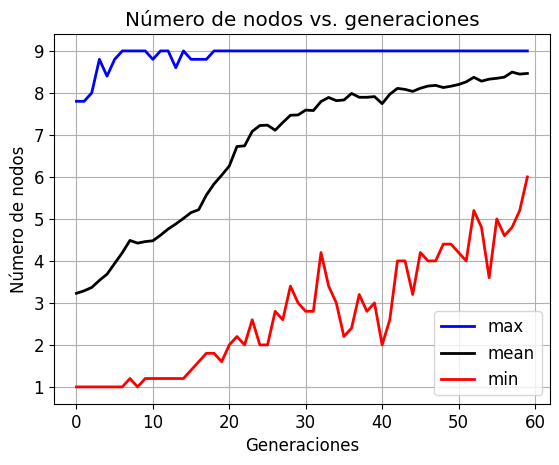

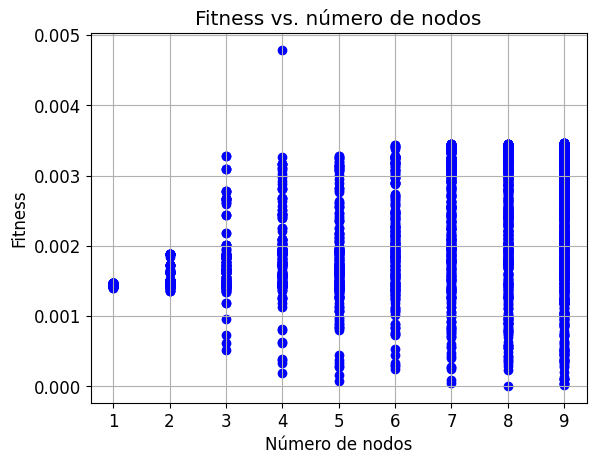

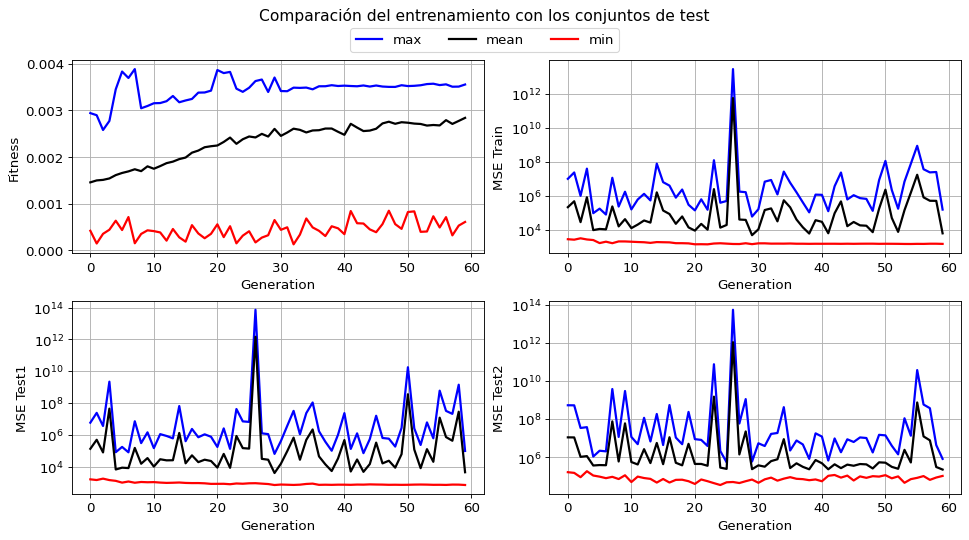

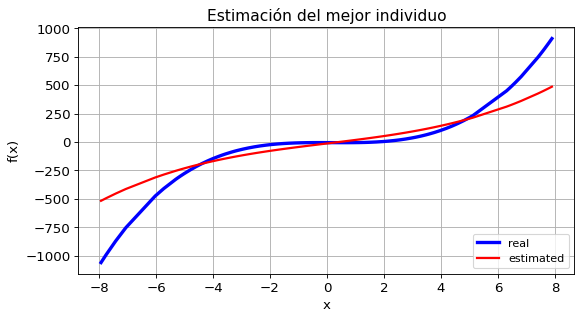

*******************************************************************
                    WINNER TREE, BEST SO FAR 
 
FITNESS     : 0.00358
MSE         : 1551.10901
DEPTH       : 9.00000
*******************************************************************
 
                        REDUCED TREE
             0.525135158225562*X1**3 + 30.44954548769448*X1 - 12.37643261039539
*******************************************************************
 
                             TREE


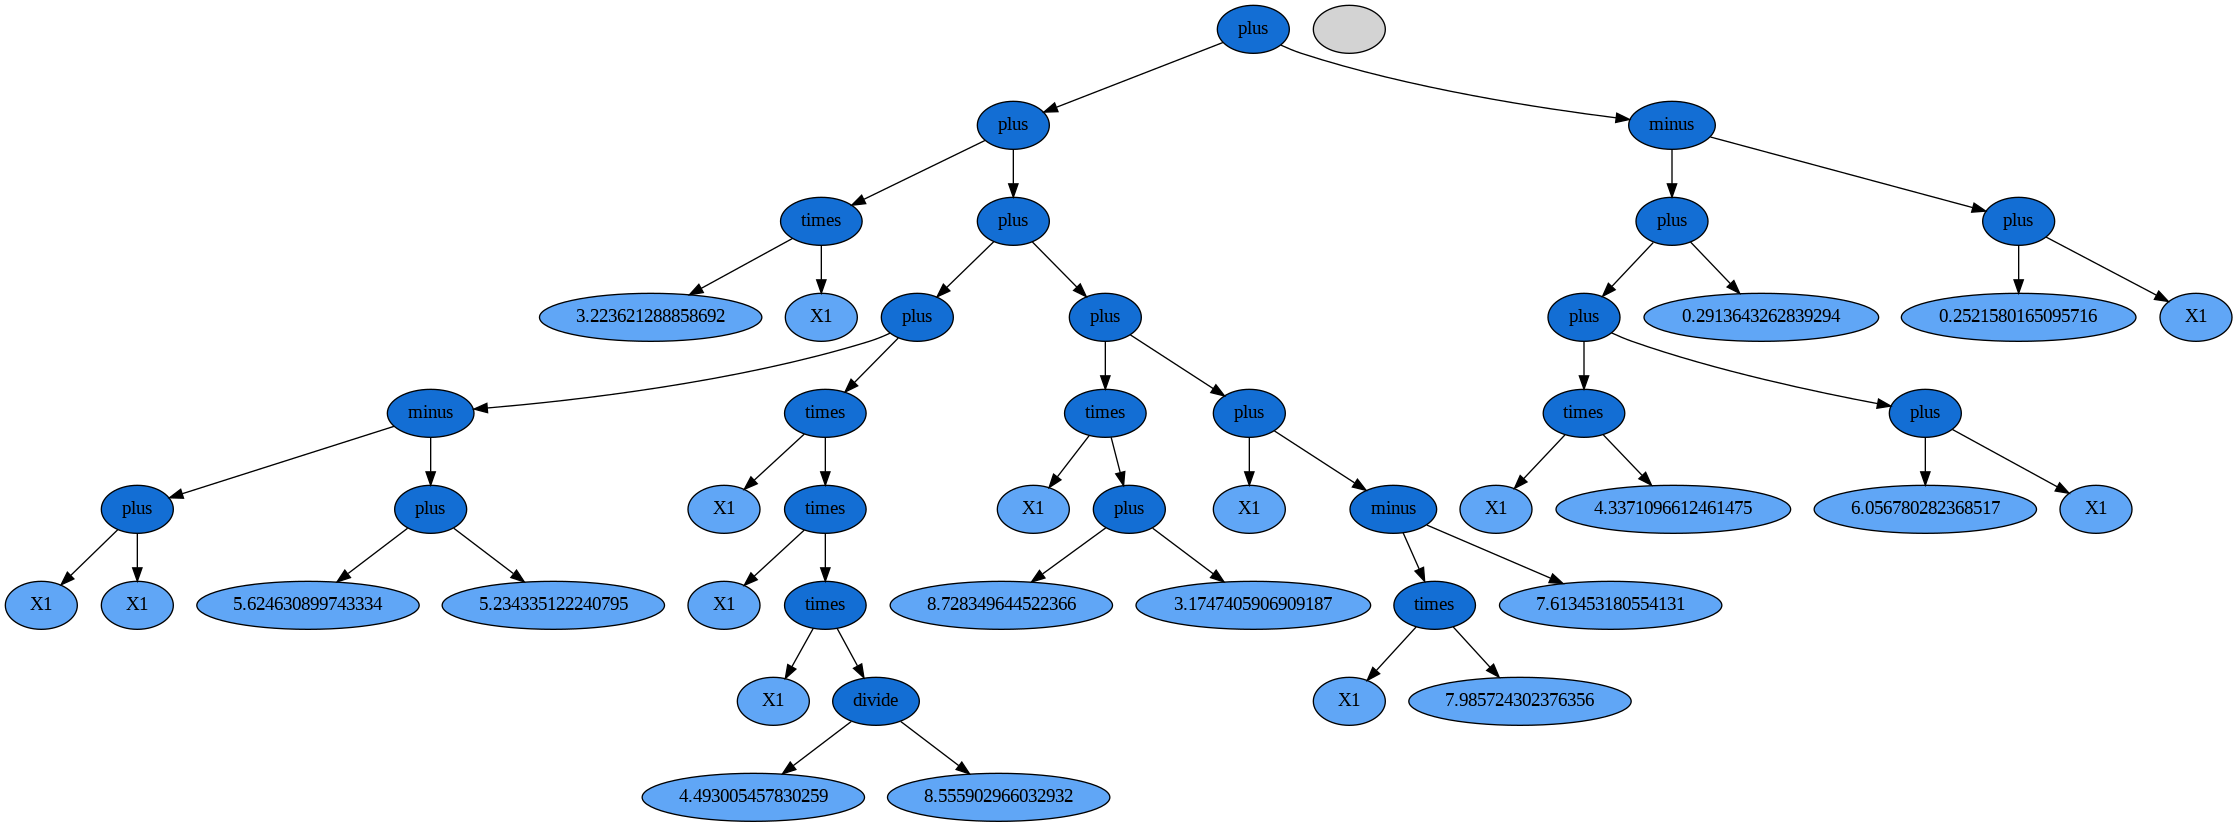

In [217]:
config.nGenerations   = 60       # numero de generaciones
config.populationSize = 50       # tamaño de la poblacion
config.maxDepth       = 8        # profundidad maxima
config.initialMinDepth= 3        # profundidad minima arboles poblacion inicial
config.initialMaxDepth= 4        # profundidad maxima arboles poblacion inicial
config.population     = 'gpalta.core.SingleTreePopulation'  # numero de salidas-arboles
config.fitness        = 'gpalta.core.FitnessClassic'        # criterio de fitness
selectedFuntion = ['Plus', 'Minus', 'Times','Divide']
# selectedFuntion = ['Plus', 'Times']
setFuntions(selectedFuntion)

# Cálculo de 5 simulaciones
Rt, mejor_individuo = n_simulations(config, 5)

# Gráficos de resultados (Complejidad de los árboles) (fitness vs. número de nodos, número de nodos vs. generaciones)
results_GP(Rt)

# Gráfica de la curva aproximada del mejor individuo seleccionado entre las 5 simulaciones (mejor fitness score)
best_tree_curve(mejor_individuo)

# Gráficos del mejor individuo seleccionado entre las 5 simulaciones (mejor fitness score)
mejor_individuo = best_tree_graph(mejor_individuo)
graph = pydotplus.graphviz.graph_from_dot_data(getTree2plot(mejor_individuo.evoStats.bestSoFar))
Image(graph.create_png())

# 2.(b) Evolución con 1000 generaciones

In [218]:
folder = 'graphs/2b'
os.makedirs(folder, exist_ok=True)

Generation:  49%|████▊     | 487/1000 [00:06<00:07, 72.61it/s]



Objective reached in generation %d 487


Generation:  26%|██▌       | 262/1000 [00:03<00:08, 84.33it/s]



Objective reached in generation %d 262
gpalta.core.Evolution@501edcf1


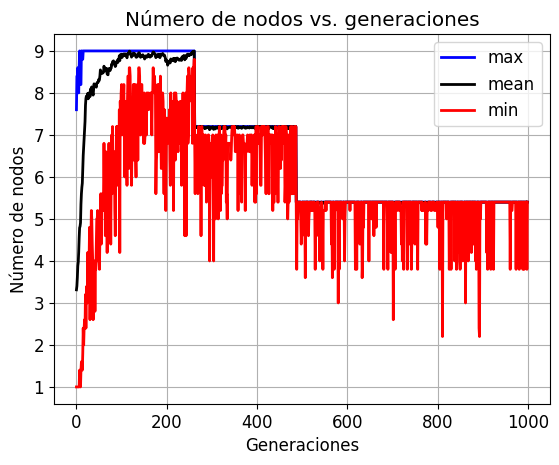

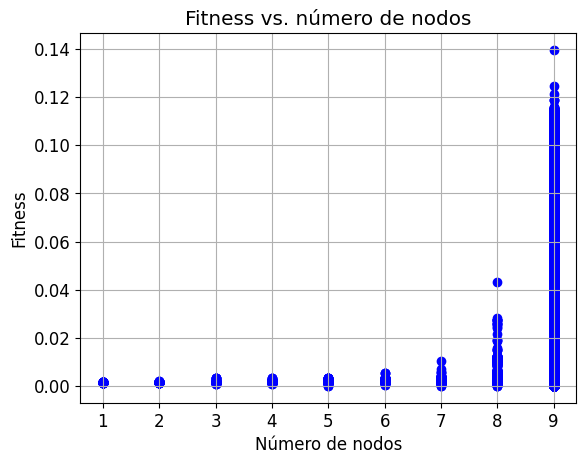

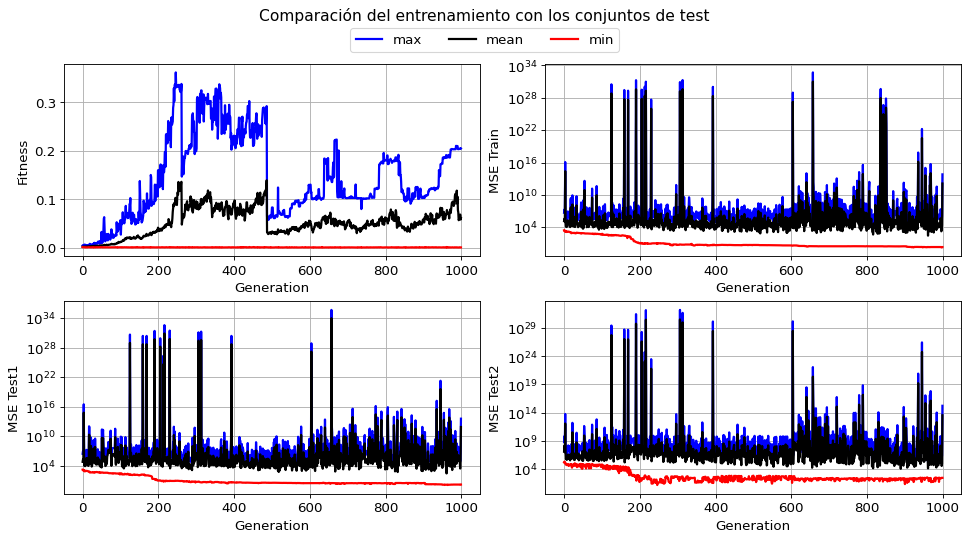

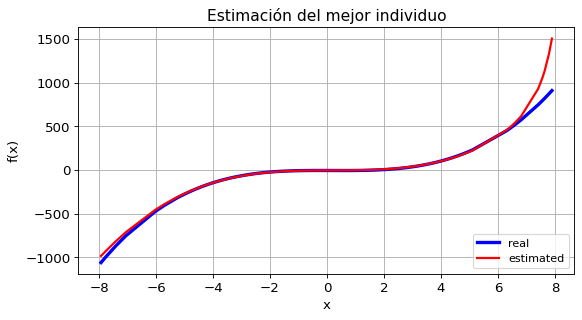

*******************************************************************
                    WINNER TREE, BEST SO FAR 
 
FITNESS     : 0.04944
MSE         : 7.39381
DEPTH       : 9.00000
*******************************************************************
 
                        REDUCED TREE
             (3783.1884291034956*X1**6 - 30791.907925564333*X1**5 - 363331.2968193205*X1**4 + 3317325.1220910722*X1**3 - 2105135.9806189371*X1**2 + 2638388.5983144974*X1 - 6061077.4271619769)/(1952.4679344942483*X1**3 - 15280.649674296104*X1**2 - 206107.64231192139*X1 + 1669475.0161234616)
*******************************************************************
 
                             TREE


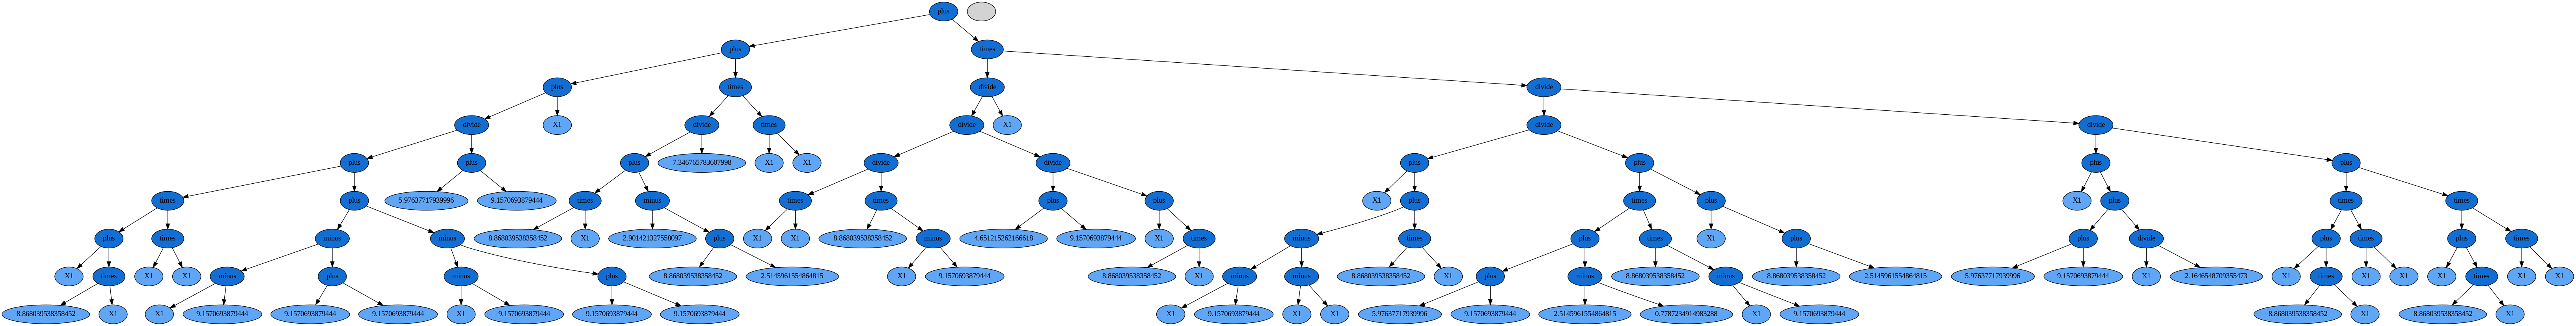

In [219]:
config.nGenerations   = 1000      # numero de generaciones

# Cálculo de 5 simulaciones
Rt, mejor_individuo = n_simulations(config, 5)

# Gráficos de resultados (Complejidad de los árboles) (fitness vs. número de nodos, número de nodos vs. generaciones)
results_GP(Rt)

# Gráfica de la curva aproximada del mejor individuo seleccionado entre las 5 simulaciones (mejor fitness score)
best_tree_curve(mejor_individuo)

# Gráficos del mejor individuo seleccionado entre las 5 simulaciones (mejor fitness score)
mejor_individuo = best_tree_graph(mejor_individuo)
graph = pydotplus.graphviz.graph_from_dot_data(getTree2plot(mejor_individuo.evoStats.bestSoFar))
Image(graph.create_png())

# 3.(a) Distintos valores de profundidad máxima

## Profundidad máxima ($PM=4$)

In [220]:
folder = 'graphs/3a/PM4'
os.makedirs(folder, exist_ok=True)

Generation: 100%|██████████| 1000/1000 [00:14<00:00, 66.76it/s]


gpalta.core.Evolution@78b729e6


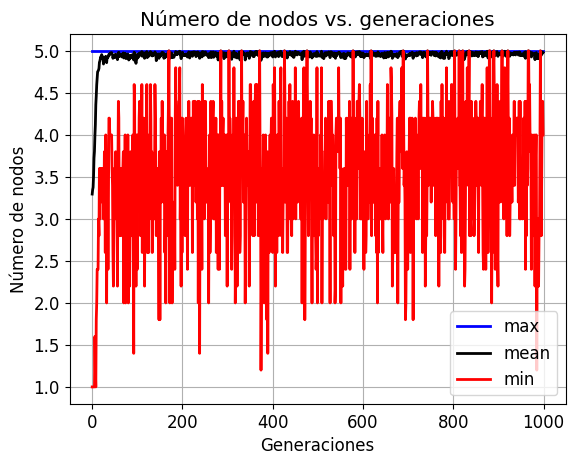

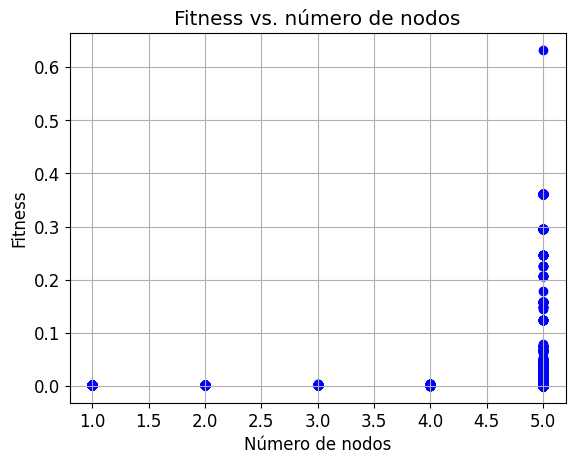

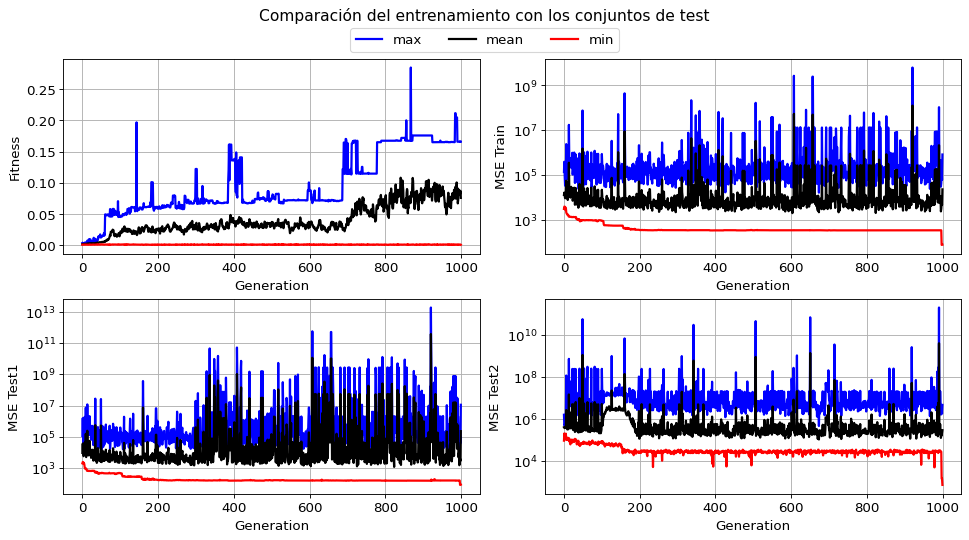

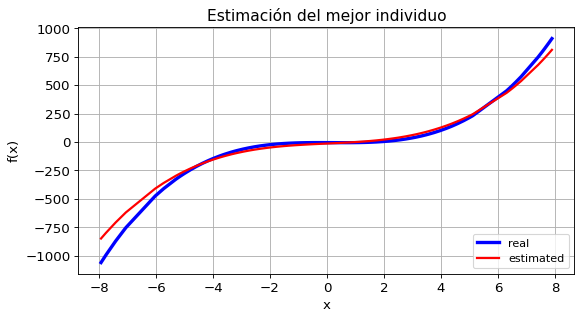

*******************************************************************
                    WINNER TREE, BEST SO FAR 
 
FITNESS     : 0.00762
MSE         : 338.98669
DEPTH       : 5.00000
*******************************************************************
 
                        REDUCED TREE
             1.4891759484269314*X1**3 + 11.44862468540027*X1 - 13.078262600776654
*******************************************************************
 
                             TREE


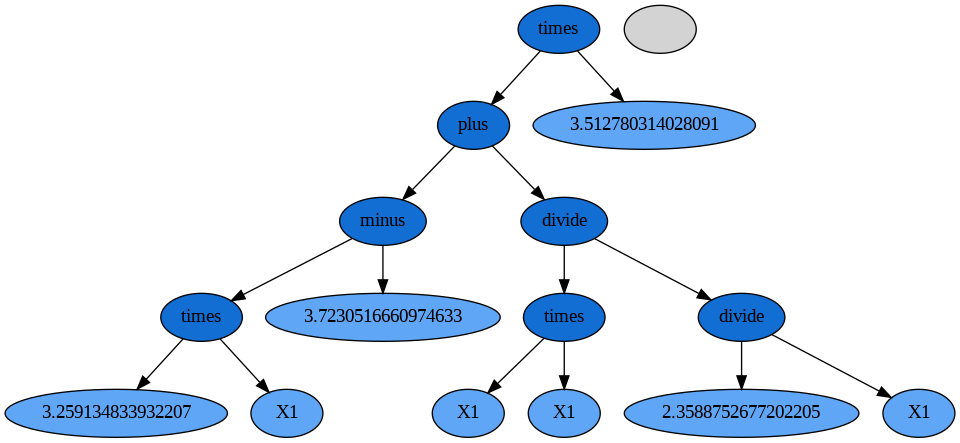

In [221]:
config.maxDepth       = 4        # profundidad maxima

# Cálculo de 5 simulaciones
Rt, mejor_individuo = n_simulations(config, 5)

# Gráficos de resultados (Complejidad de los árboles) (fitness vs. número de nodos, número de nodos vs. generaciones)
results_GP(Rt)

# Gráfica de la curva aproximada del mejor individuo seleccionado entre las 5 simulaciones (mejor fitness score)
best_tree_curve(mejor_individuo)

# Gráficos del mejor individuo seleccionado entre las 5 simulaciones (mejor fitness score)
mejor_individuo = best_tree_graph(mejor_individuo)
graph = pydotplus.graphviz.graph_from_dot_data(getTree2plot(mejor_individuo.evoStats.bestSoFar))
Image(graph.create_png())

## Profundidad máxima ($PM=14$)

In [222]:
folder = 'graphs/3a/PM14'
os.makedirs(folder, exist_ok=True)

Generation: 100%|██████████| 1000/1000 [00:40<00:00, 24.61it/s]


gpalta.core.Evolution@6b4a4e18


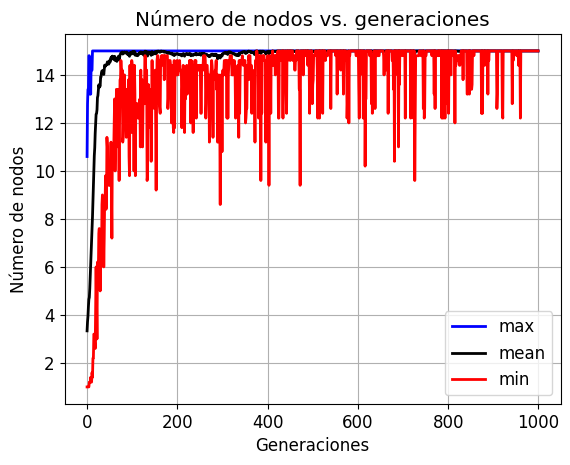

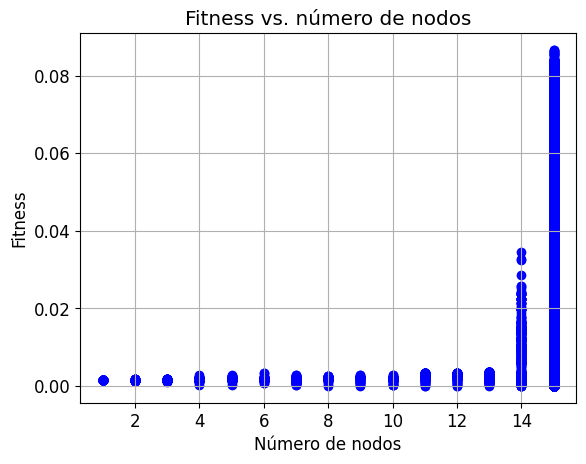

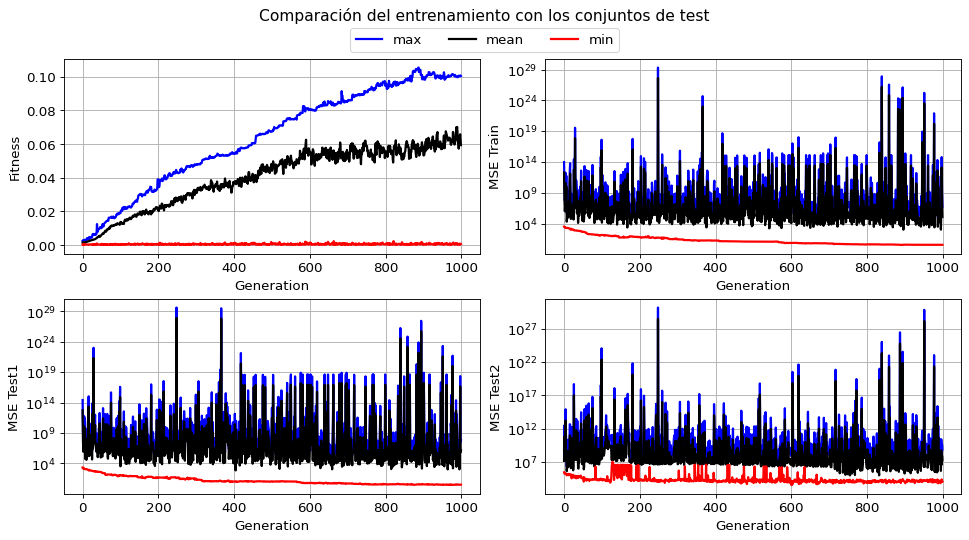

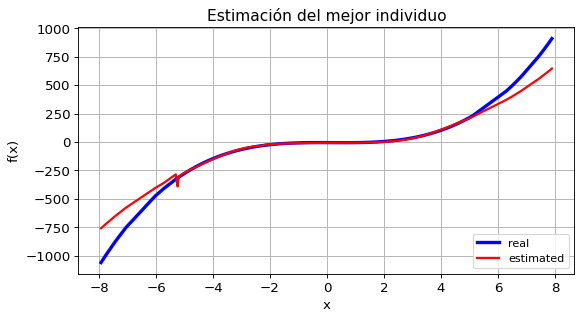

*******************************************************************
                    WINNER TREE, BEST SO FAR 
 
FITNESS     : 0.03936
MSE         : 11.91314
DEPTH       : 15.00000
*******************************************************************
 
                        REDUCED TREE
             X1**2*(X1 - 0.6431665564489109) - 0.01728571196288388*X1**2*(X1 - 0.6431665564489109)*(8.36087640500918*X1**2 - 8.36087640500918*X1)/((0.1223451234749231*X1 + 0.6431665564489109)*(-X1 + 0.6796672303093221 + 0.01851064818232004*(X1 + 1.0884016643848668/(X1*(8.36087640500918*X1**2 - 8.36087640500918*X1)))/X1)*(-0.8776548765250769*X1 + 9.132215206419607 + 1.139400038383342/(X1**2*(X1 - 0.6431665564489109)))*(0.8776548765250769*X1**3 + 2.318235790603201*X1**2 + 1.318235790603201*X1 + 1.0*(9.132215206419607 - 9.779361311483065/X1**2)/X1**2)) + X1 + 5.915646799496247*X1/(0.25698659083534198 - 11.23403258190591*(0.002264687537466807*X1*(0.8776548765250769*X1 - 0.6431665564489109)*(X1 - 0.643166

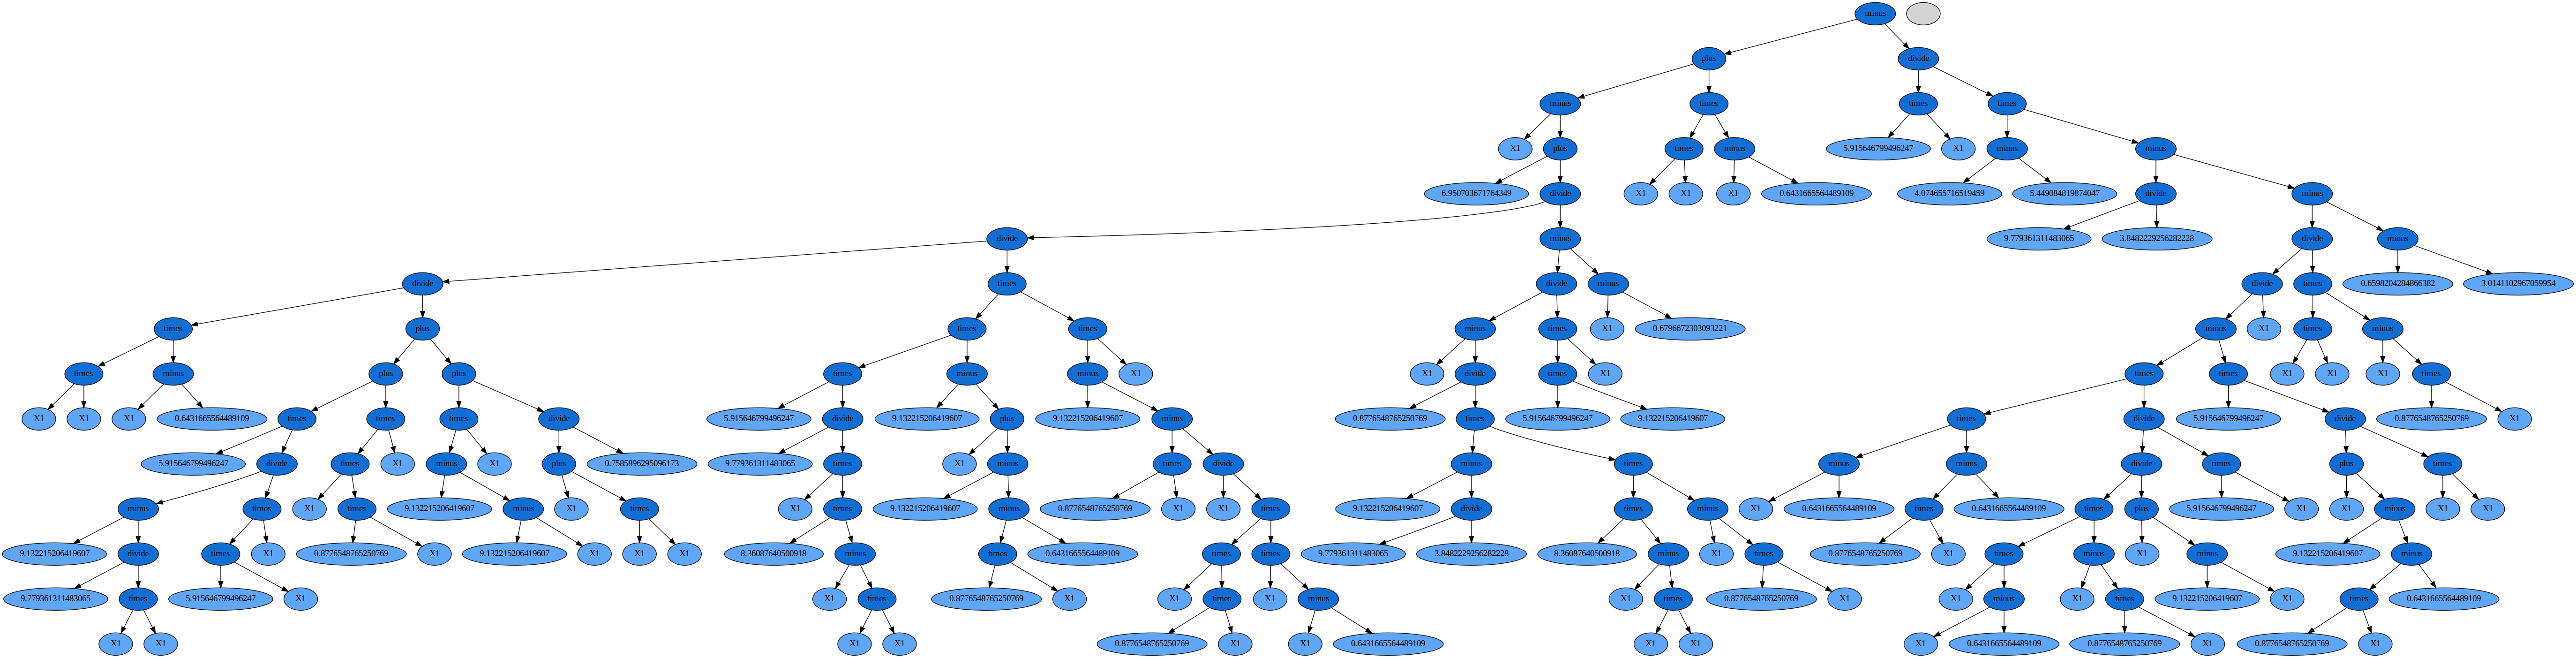

In [223]:
config.maxDepth       = 14        # profundidad maxima

# Cálculo de 5 simulaciones
Rt, mejor_individuo = n_simulations(config, 5)

# Gráficos de resultados (Complejidad de los árboles) (fitness vs. número de nodos, número de nodos vs. generaciones)
results_GP(Rt)

# Gráfica de la curva aproximada del mejor individuo seleccionado entre las 5 simulaciones (mejor fitness score)
best_tree_curve(mejor_individuo)

# Gráficos del mejor individuo seleccionado entre las 5 simulaciones (mejor fitness score)
mejor_individuo = best_tree_graph(mejor_individuo)
graph = pydotplus.graphviz.graph_from_dot_data(getTree2plot(mejor_individuo.evoStats.bestSoFar))
Image(graph.create_png())

# 3.(b) Distintos valores de máximo de generaciones

## Número máximo de generaciones ($NMG=12$)

In [224]:
folder = 'graphs/3b/NMG12'
os.makedirs(folder, exist_ok=True)

Generation: 100%|██████████| 12/12 [00:00<00:00, 97.40it/s]


gpalta.core.Evolution@27c86f2d


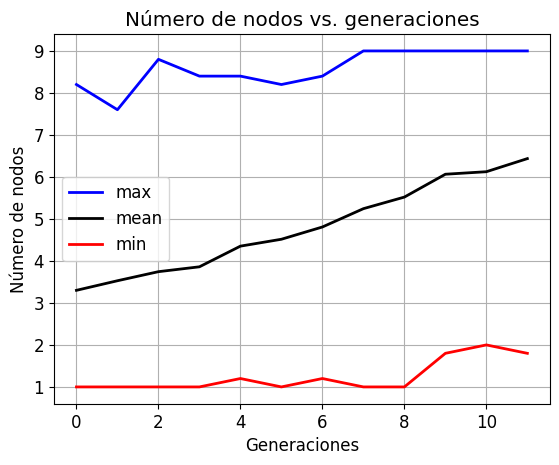

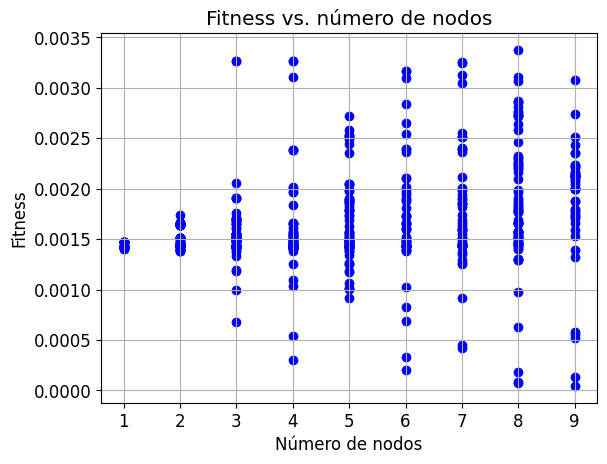

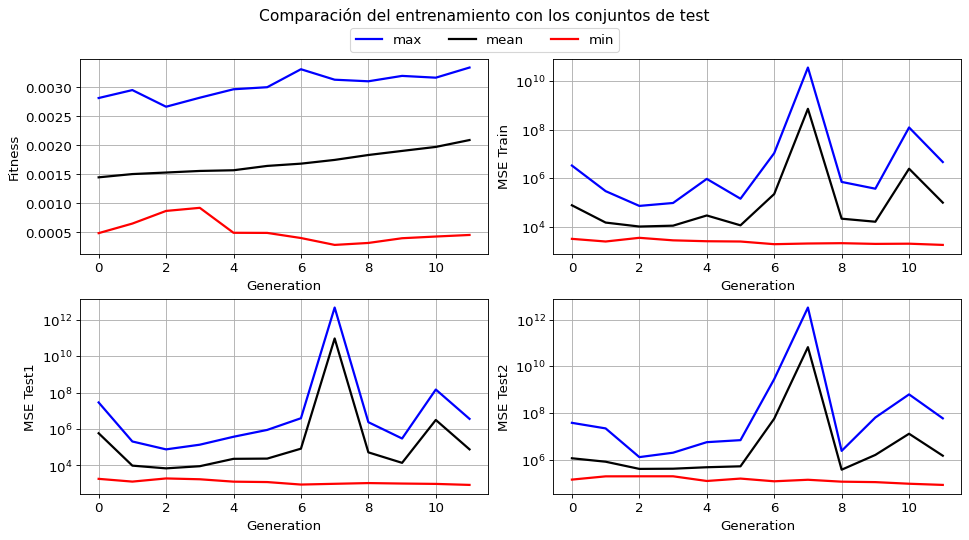

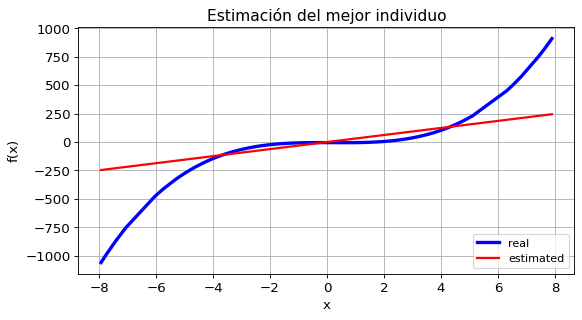

*******************************************************************
                    WINNER TREE, BEST SO FAR 
 
FITNESS     : 0.00327
MSE         : 1855.69887
DEPTH       : 5.00000
*******************************************************************
 
                        REDUCED TREE
             30.964989328182186*X1
*******************************************************************
 
                             TREE


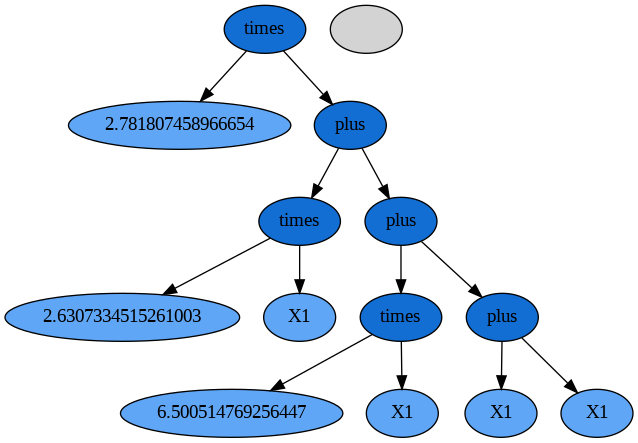

In [225]:
config.nGenerations   = 12       # numero de generaciones
# config.populationSize = 50       # tamaño de la poblacion
config.maxDepth       = 8        # profundidad maxima

# Cálculo de 5 simulaciones
Rt, mejor_individuo = n_simulations(config, 5)

# Gráficos de resultados (Complejidad de los árboles) (fitness vs. número de nodos, número de nodos vs. generaciones)
results_GP(Rt)

# Gráfica de la curva aproximada del mejor individuo seleccionado entre las 5 simulaciones (mejor fitness score)
best_tree_curve(mejor_individuo)

# Gráficos del mejor individuo seleccionado entre las 5 simulaciones (mejor fitness score)
mejor_individuo = best_tree_graph(mejor_individuo)
graph = pydotplus.graphviz.graph_from_dot_data(getTree2plot(mejor_individuo.evoStats.bestSoFar))
Image(graph.create_png())

## Número máximo de generaciones ($NMG=100$)

In [228]:
folder = 'graphs/3b/NMG100'
os.makedirs(folder, exist_ok=True)

Generation: 100%|██████████| 100/100 [00:01<00:00, 61.59it/s]


gpalta.core.Evolution@402e37bc


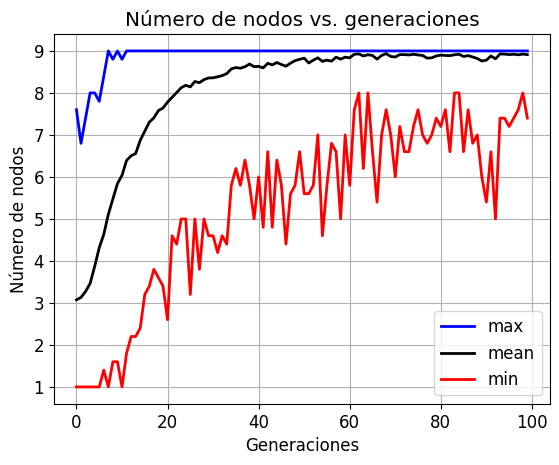

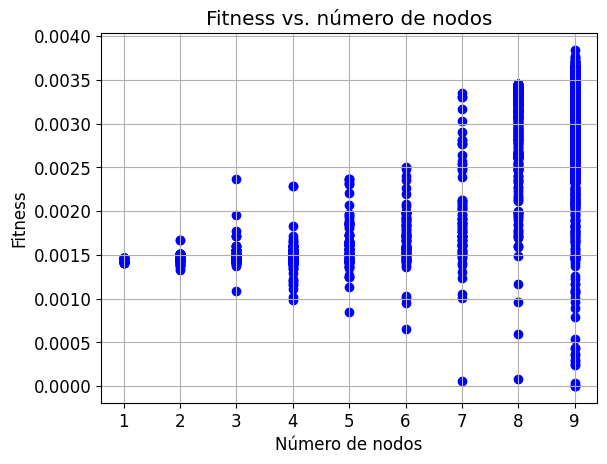

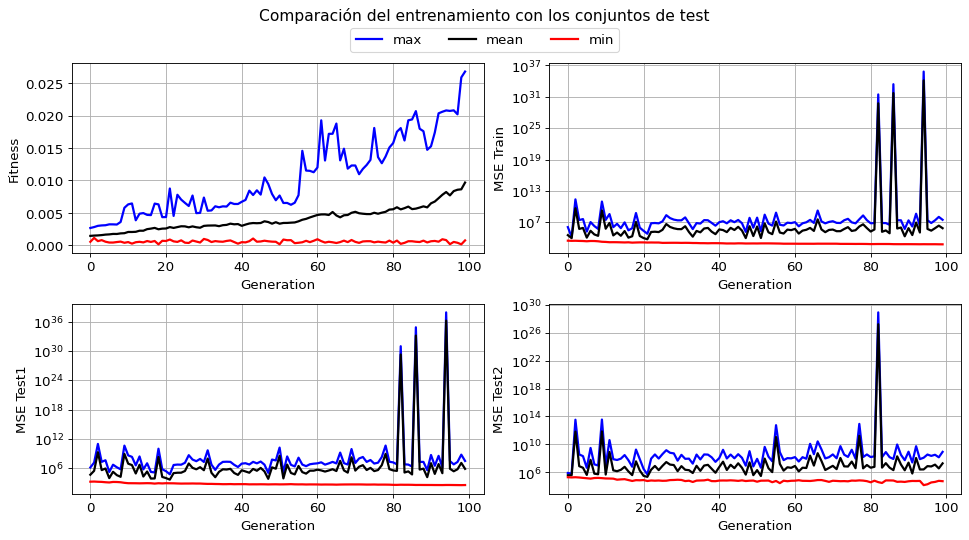

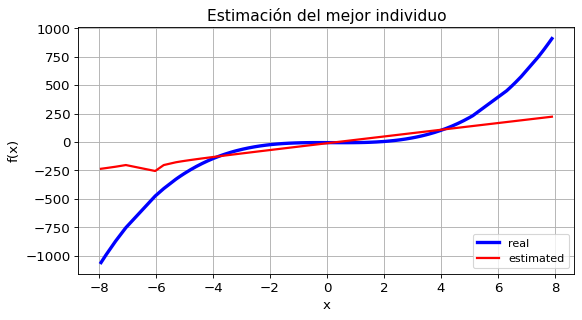

*******************************************************************
                    WINNER TREE, BEST SO FAR 
 
FITNESS     : 0.00350
MSE         : 1618.19196
DEPTH       : 9.00000
*******************************************************************
 
                        REDUCED TREE
             (455.2214161895774*X1**2 + 2694.683212343323*X1 - 1001.734471547279)/(15.48591127330481*X1 + 96.13948620453075)
*******************************************************************
 
                             TREE


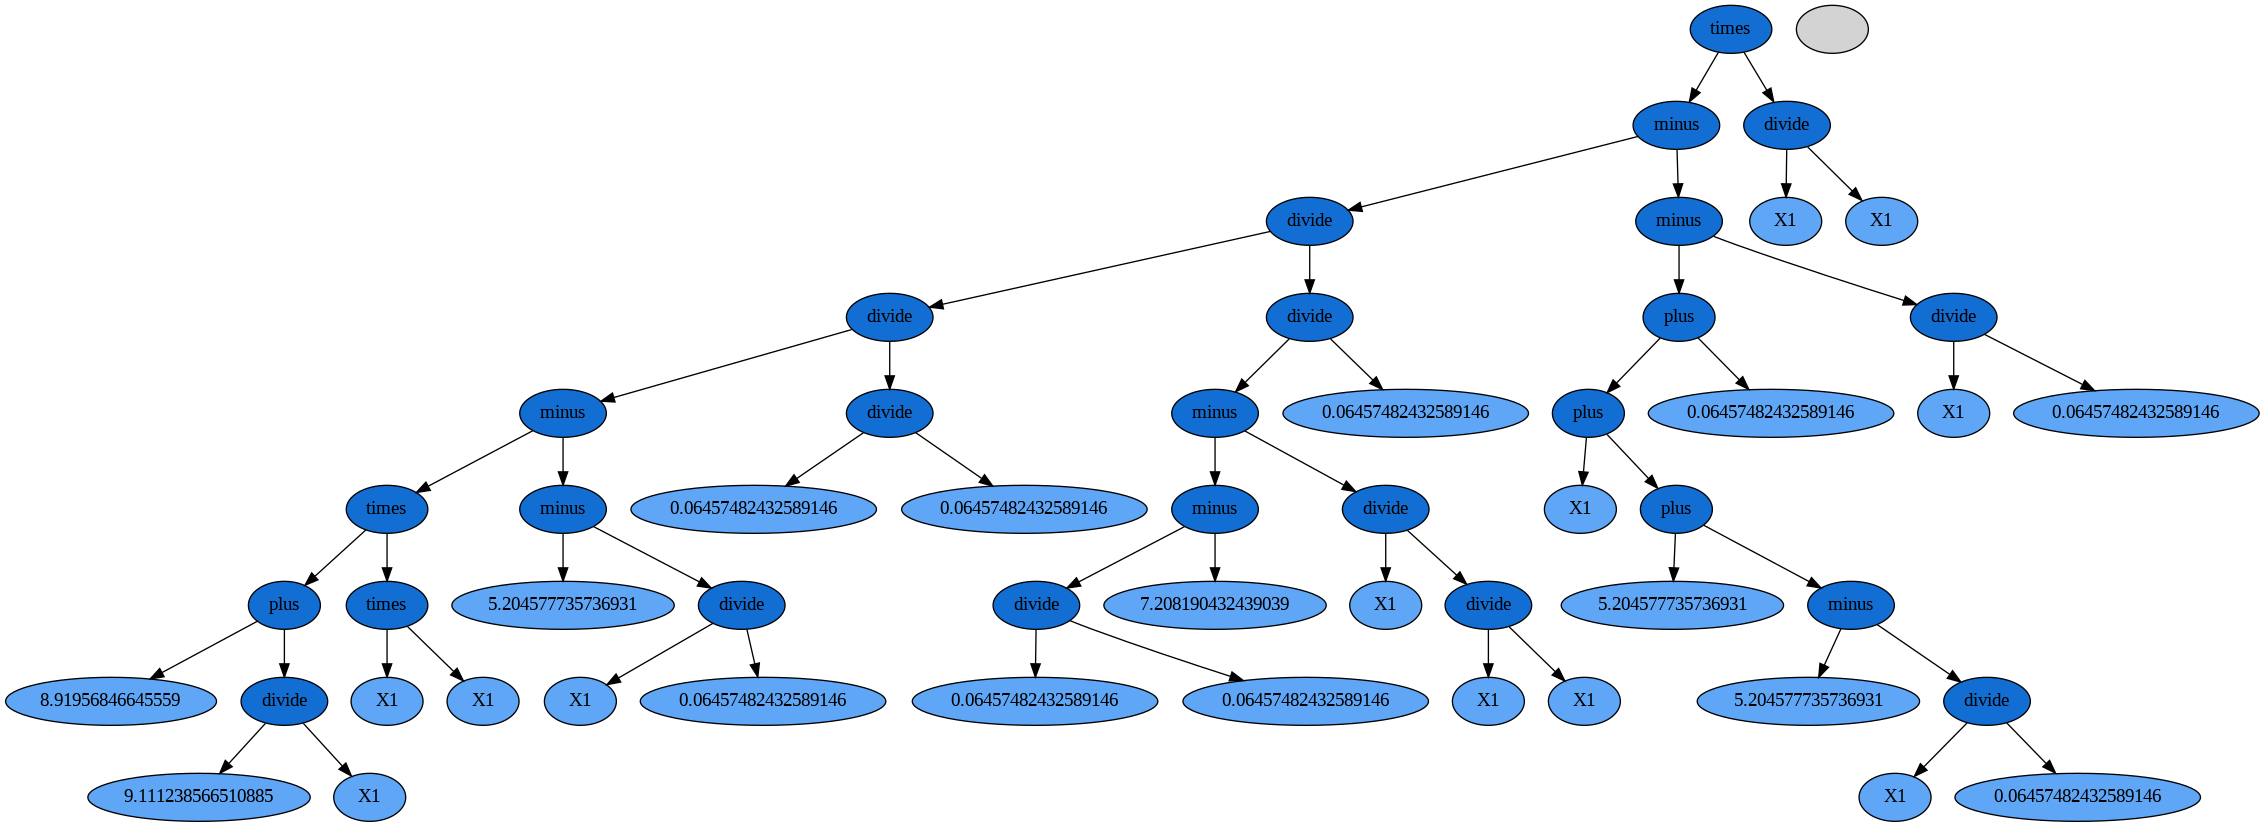

In [229]:
config.nGenerations   = 100       # numero de generaciones
# config.populationSize = 50       # tamaño de la poblacion
# config.maxDepth       = 8        # profundidad maxima

# Cálculo de 5 simulaciones
Rt, mejor_individuo = n_simulations(config, 5)

# Gráficos de resultados (Complejidad de los árboles) (fitness vs. número de nodos, número de nodos vs. generaciones)
results_GP(Rt)

# Gráfica de la curva aproximada del mejor individuo seleccionado entre las 5 simulaciones (mejor fitness score)
best_tree_curve(mejor_individuo)

# Gráficos del mejor individuo seleccionado entre las 5 simulaciones (mejor fitness score)
mejor_individuo = best_tree_graph(mejor_individuo)
graph = pydotplus.graphviz.graph_from_dot_data(getTree2plot(mejor_individuo.evoStats.bestSoFar))
Image(graph.create_png())

# 3.(c) Distintos valores de mutación crossover y selección

## Probabilidad de mutación ($MUT=0.05$)

In [234]:
folder = 'graphs/3c/MUT'
os.makedirs(folder, exist_ok=True)

Generation:  58%|█████▊    | 581/1000 [00:14<00:10, 41.42it/s]



Objective reached in generation %d 581
gpalta.core.Evolution@1ffe63b9


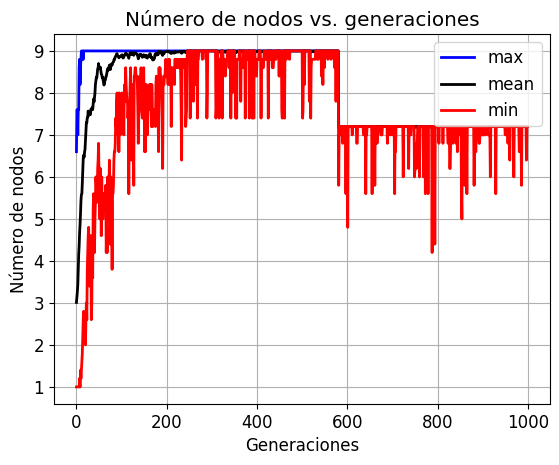

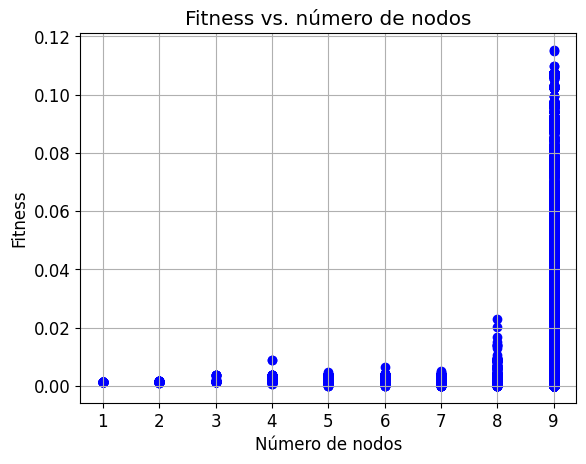

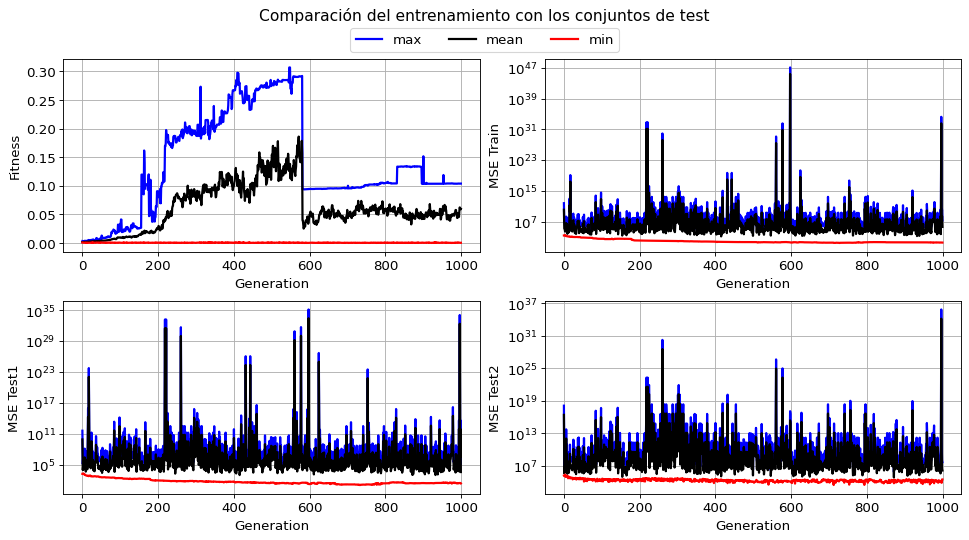

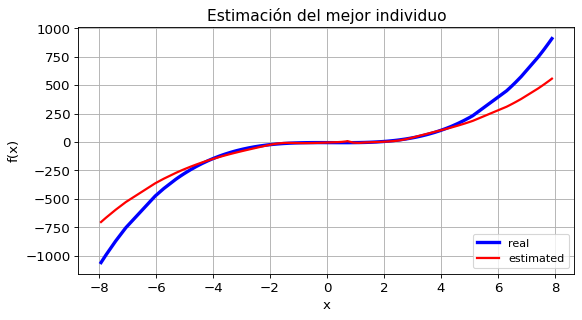

*******************************************************************
                    WINNER TREE, BEST SO FAR 
 
FITNESS     : 0.01165
MSE         : 143.98033
DEPTH       : 9.00000
*******************************************************************
 
                        REDUCED TREE
             (2.978188329789881*X1**13 - 15.882805806502876*X1**12 + 63.728229276795267*X1**11 - 182.37283951677096*X1**10 - 14.270118918975136*X1**9 + 1117.2353804731258*X1**8 - 894.69176667508126*X1**7 - 2703.0762626866607*X1**6 + 3120.5419048049166*X1**5 + 3033.3125240590865*X1**4 - 4724.000788755273*X1**3 - 2053.4536410639963*X1**2 + 4472.4955579847899*X1 - 1278.1578062047326)/(2.978188329789881*X1**10 - 12.904617476712995*X1**9 - 0.20357440328733062*X1**8 + 59.179937534475857*X1**7 - 3.3072009934383355*X1**6 - 188.80627533987383*X1**5 + 177.21838758773488*X1**4 + 296.39668163627646*X1**3 - 233.88327626927538*X1**2 - 382.78888642290121*X1 + 286.45716633600399)
************************************

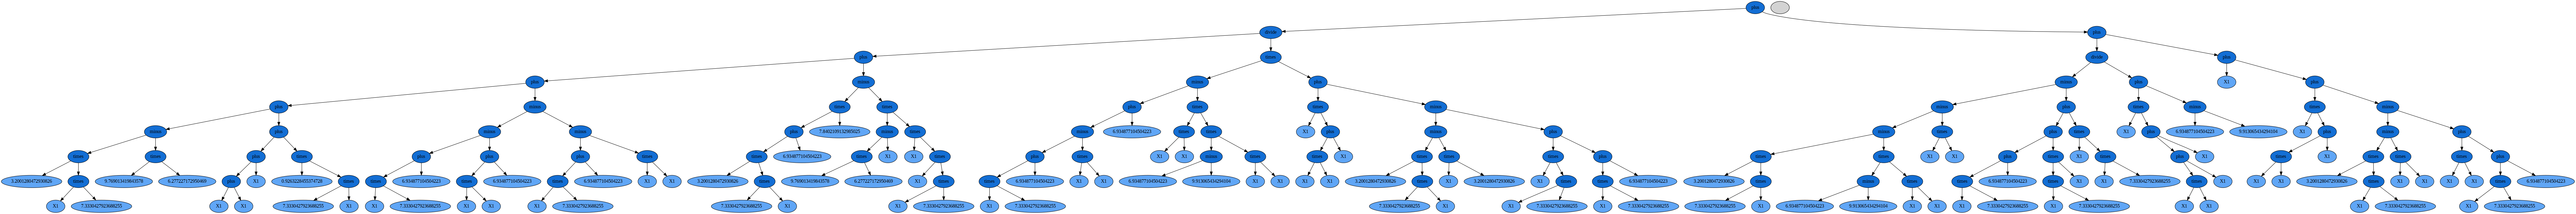

In [235]:
config.nGenerations   = 1000       # numero de generaciones
config.populationSize = 50       # tamaño de la poblacion
config.maxDepth       = 8        # profundidad maxima

prob_mutation         = 0.05 #0.15
prob_crossover        = 0.7
# probability of crossover = upLimitProbCrossOver - 0
# probability of mutation = upLimitProbMutation - upLimitProbCrossOver
# probability of reproduction = 1 - upLimitProbMutation
config.upLimitProbCrossOver = prob_crossover
config.upLimitProbMutation  = prob_mutation + prob_crossover

# Cálculo de 5 simulaciones
Rt, mejor_individuo = n_simulations(config, 5)

# Gráficos de resultados (Complejidad de los árboles) (fitness vs. número de nodos, número de nodos vs. generaciones)
results_GP(Rt)

# Gráfica de la curva aproximada del mejor individuo seleccionado entre las 5 simulaciones (mejor fitness score)
best_tree_curve(mejor_individuo)

# Gráficos del mejor individuo seleccionado entre las 5 simulaciones (mejor fitness score)
mejor_individuo = best_tree_graph(mejor_individuo)
graph = pydotplus.graphviz.graph_from_dot_data(getTree2plot(mejor_individuo.evoStats.bestSoFar))
Image(graph.create_png())

## Probabilidad de crossover ($NMG=0.6$)

In [232]:
folder = 'graphs/3b/CROSS'
os.makedirs(folder, exist_ok=True)

Generation:  90%|████████▉ | 895/1000 [00:25<00:02, 35.07it/s]



Objective reached in generation %d 895


Generation:  98%|█████████▊| 978/1000 [00:26<00:00, 36.47it/s]



Objective reached in generation %d 978


Generation: 100%|██████████| 1000/1000 [00:28<00:00, 35.63it/s]


gpalta.core.Evolution@5dd6264


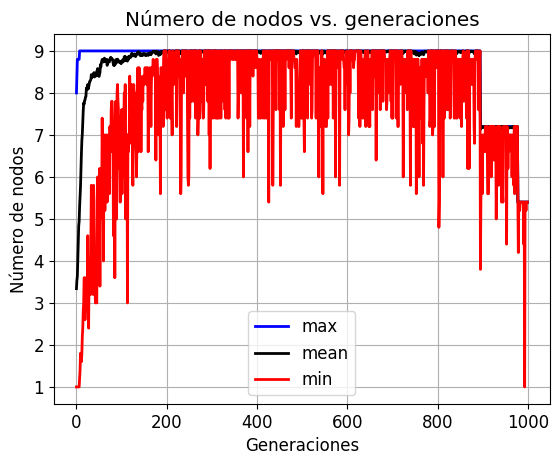

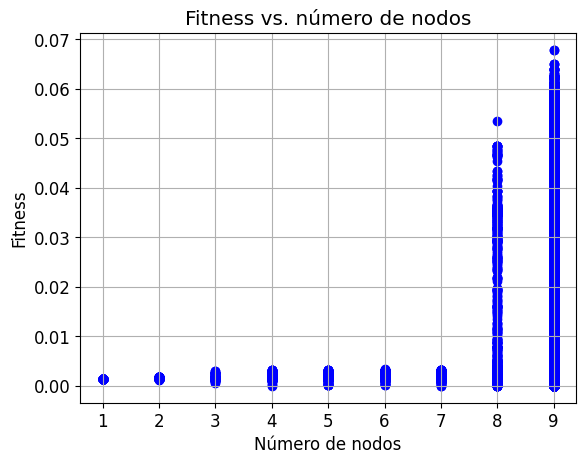

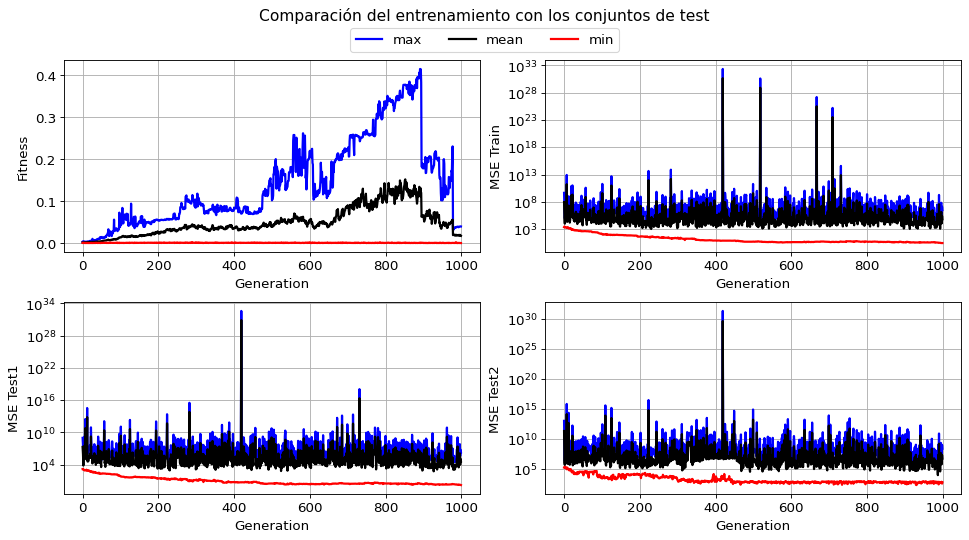

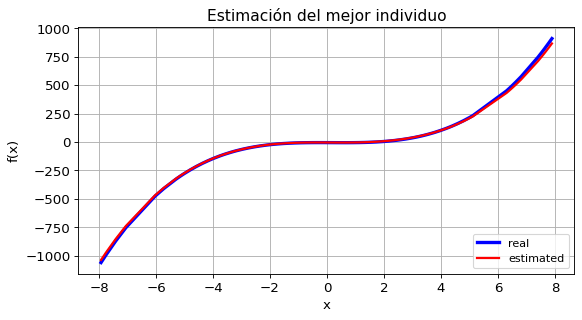

*******************************************************************
                    WINNER TREE, BEST SO FAR 
 
FITNESS     : 0.06789
MSE         : 3.77020
DEPTH       : 9.00000
*******************************************************************
 
                        REDUCED TREE
             (31.310662720315223*X1**7 - 60.192620542047493*X1**6 + 673.65221246516492*X1**5 - 738.76685056799414*X1**4 + 2965.8772583475554*X1**3 - 2013.6973406406622*X1**2 - 1013.3836235892754*X1 - 5336.9476472752474)/(16.351564702422469*X1**4 - 20.66649534251473*X1**3 + 338.19577862282444*X1**2 - 176.7244451440723*X1 + 1325.4673561736434)
*******************************************************************
 
                             TREE


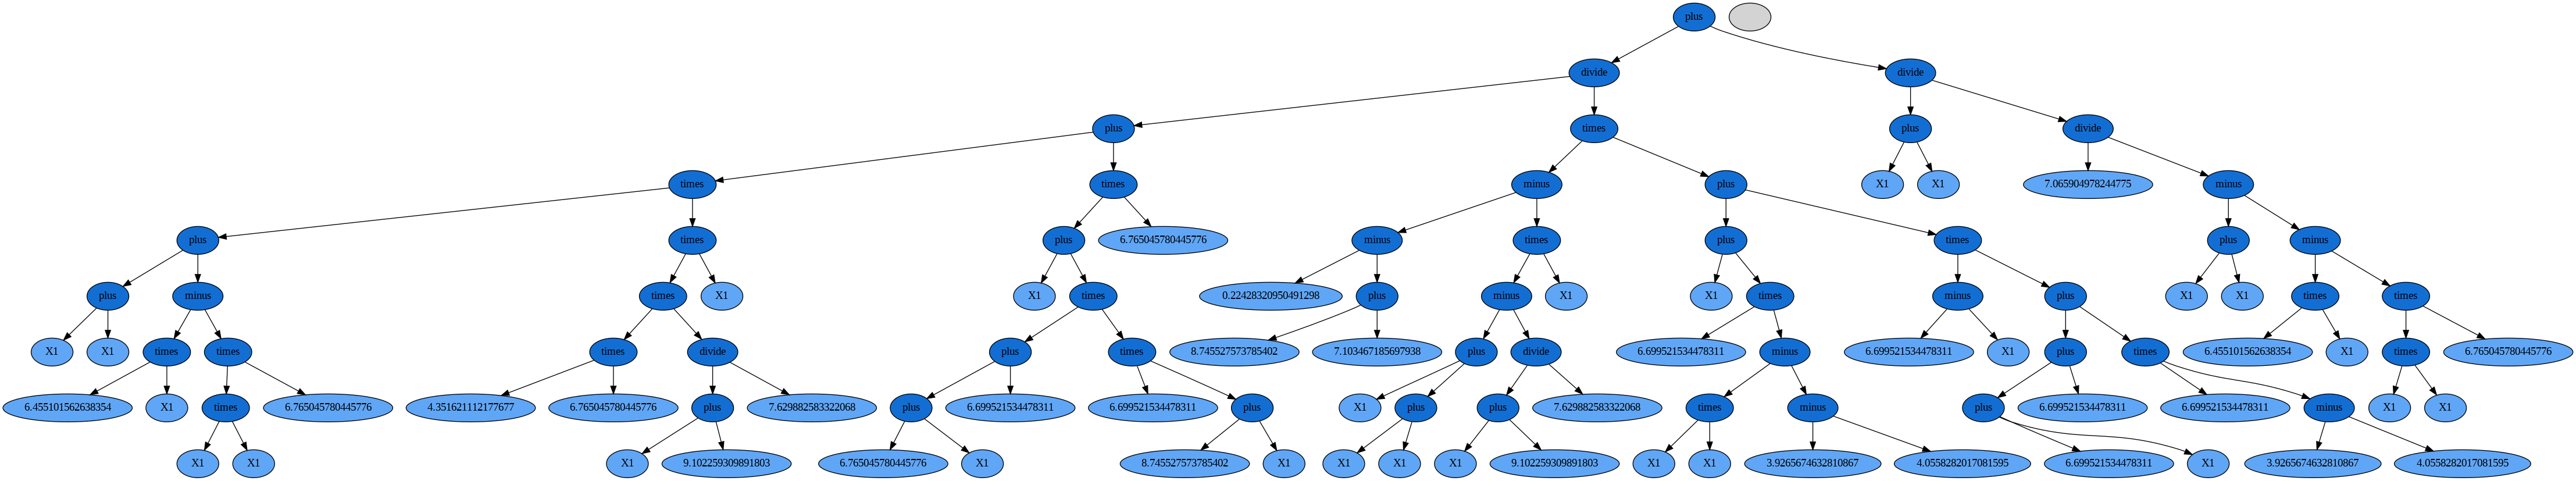

In [233]:
config.nGenerations   = 1000       # numero de generaciones
config.populationSize = 50       # tamaño de la poblacion
config.maxDepth       = 8        # profundidad maxima

prob_mutation         = 0.15
prob_crossover        = 0.6
# probability of crossover = upLimitProbCrossOver - 0
# probability of mutation = upLimitProbMutation - upLimitProbCrossOver
# probability of reproduction = 1 - upLimitProbMutation
config.upLimitProbCrossOver = prob_crossover
config.upLimitProbMutation  = prob_mutation + prob_crossover

# Cálculo de 5 simulaciones
Rt, mejor_individuo = n_simulations(config, 5)

# Gráficos de resultados (Complejidad de los árboles) (fitness vs. número de nodos, número de nodos vs. generaciones)
results_GP(Rt)

# Gráfica de la curva aproximada del mejor individuo seleccionado entre las 5 simulaciones (mejor fitness score)
best_tree_curve(mejor_individuo)

# Gráficos del mejor individuo seleccionado entre las 5 simulaciones (mejor fitness score)
mejor_individuo = best_tree_graph(mejor_individuo)
graph = pydotplus.graphviz.graph_from_dot_data(getTree2plot(mejor_individuo.evoStats.bestSoFar))
Image(graph.create_png())

# Encontrando la mejor predicción

In [236]:
folder = 'graphs/mejor'
os.makedirs(folder, exist_ok=True)

Generation: 100%|██████████| 2000/2000 [00:26<00:00, 74.41it/s]


gpalta.core.Evolution@7ee955a8


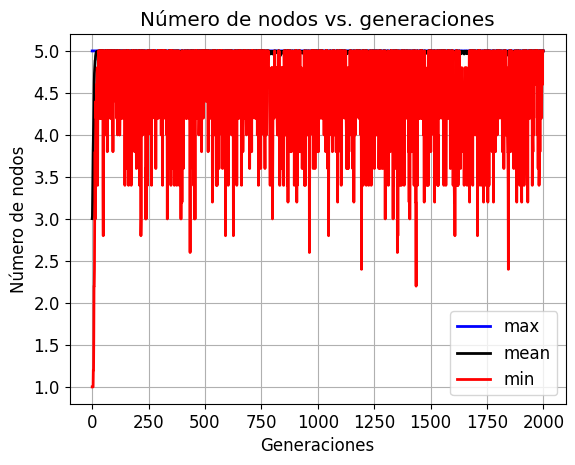

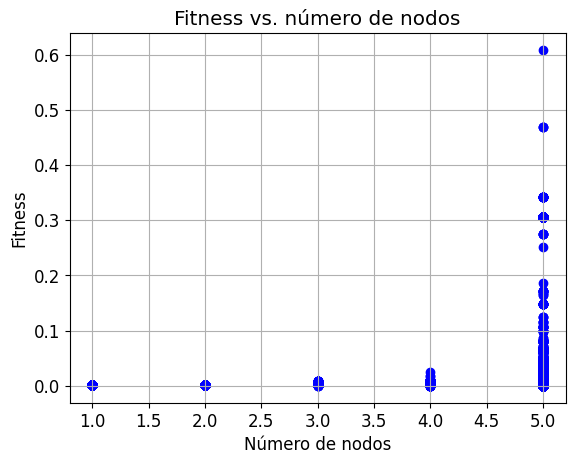

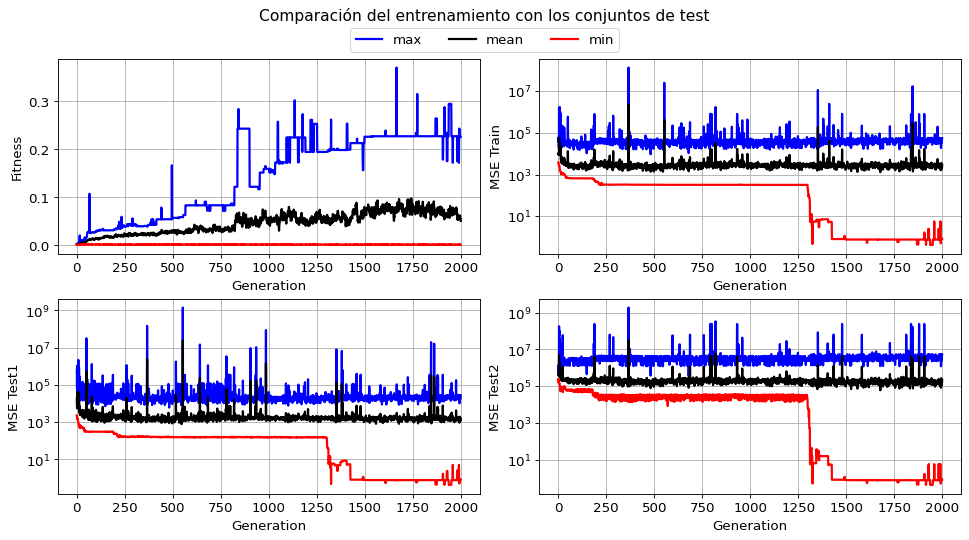

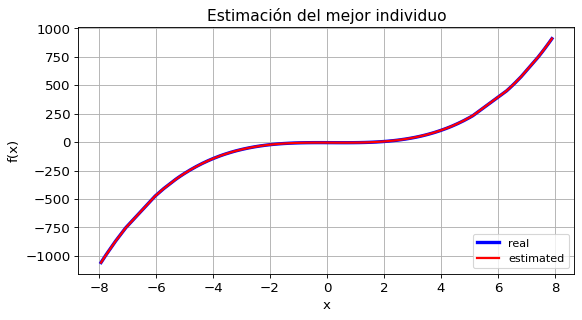

*******************************************************************
                    WINNER TREE, BEST SO FAR 
 
FITNESS     : 0.34234
MSE         : 0.07381
DEPTH       : 5.00000
*******************************************************************
 
                        REDUCED TREE
             2*X1**3 - X1**2 - 0.9341888587060331*X1 - 4.8096147031794
*******************************************************************
 
                             TREE


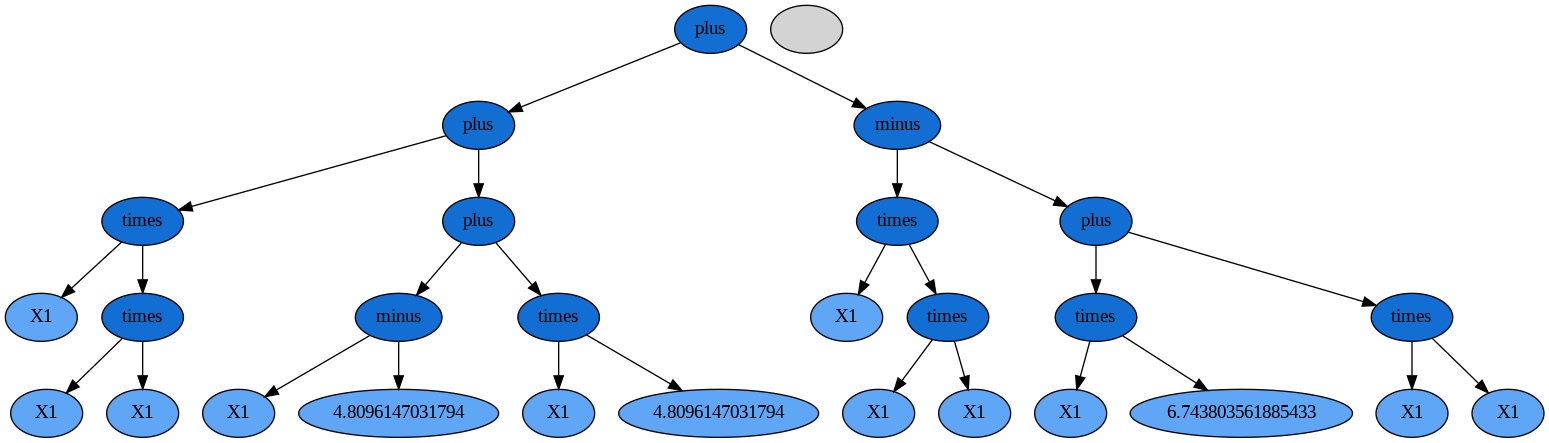

In [240]:
config.nGenerations   = 2000     # numero de generaciones
config.populationSize = 60      # tamaño de la poblacion
config.maxDepth       = 4        # profundidad maxima
prob_mutation         = 0.15
prob_crossover        = 0.7

# Cálculo de 5 simulaciones
Rt, mejor_individuo = n_simulations(config, 5)

# Gráficos de resultados (Complejidad de los árboles) (fitness vs. número de nodos, número de nodos vs. generaciones)
results_GP(Rt)

# Gráfica de la curva aproximada del mejor individuo seleccionado entre las 5 simulaciones (mejor fitness score)
best_tree_curve(mejor_individuo)

# Gráficos del mejor individuo seleccionado entre las 5 simulaciones (mejor fitness score)
mejor_individuo = best_tree_graph(mejor_individuo)
graph = pydotplus.graphviz.graph_from_dot_data(getTree2plot(mejor_individuo.evoStats.bestSoFar))
Image(graph.create_png())

In [241]:
# Finalizar máquina virtual de java
# Ejecute este comando sólo cuando termine la sesión. Al cerrar la máquina virtual, no es posible graficar árboles

jpype.shutdownJVM()